# Workshop 7
## Unsupervised Machine Learning

In [2]:
%matplotlib inline
# There are a lot of imports here but don't worry about them
#  you can easily figure out when you need them from the docs
#  you wouldn't be expect to know or remember these
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
#import nibabel as nib
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, mixture, manifold, random_projection
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
global_palette = 'Spectral'

## The following cells load in the data and show a small amount of info on them

In [4]:
# Dictionary for all datasets - each entry to store (x, labels)
datasets={}

(70, 205)


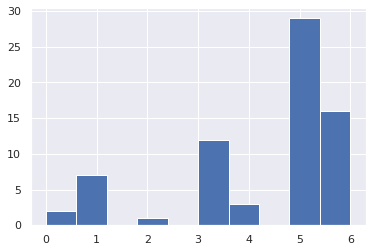

In [5]:
# Dataset on children with physical and motor disabilities
# https://archive.ics.uci.edu/ml/datasets/SCADI
data = pd.read_csv('SCADI.csv')
x = data.iloc[:,:-1].to_numpy(dtype=np.float64)
labels = data["Classes"].astype('category').cat.codes.to_numpy()
datasets['scadi'] = (x, labels)
print(x.shape)

# visualise data
#data.info()
#print(data.describe())
plt.hist(labels)
plt.show()

In [6]:
# Brain MRI image slice
im = nib.load('T1_brain.nii.gz').get_data()
x_im = im[:,:,95]
nx, ny = x_im.shape
x = x_im.reshape(-1,1)  # force it to be a 2D array with one column (consistent with other datasets)
# Can go back to original 2D image (for display later on) with reshape((nx,ny))
labels = None
datasets['brain'] = (x, labels)
print(x.shape)

# visualise data
plt.hist(x[x>0],70)
plt.show()

plt.imshow(x_im, cmap='gray')
plt.grid(None)
plt.show()

NameError: name 'nib' is not defined

In [7]:
# Breast cancer data
data = load_breast_cancer()
x = data['data']
labels = data['target']
datasets['breast'] = (x, labels)
print(x.shape)

(569, 30)


In [8]:
# Classic Iris dataset
iris = load_iris()
x = iris.data
labels = iris.target
datasets['iris'] = (x, labels)
print(x.shape)

(150, 4)


In [9]:
# Interesting 2D data
data = np.load('clusterable_data.npy')
x = data
labels = None
datasets['interesting'] = (x, labels)
print(x.shape)

(2309, 2)


In [10]:
# Artificial dataset
blobs = make_blobs(n_samples=200, centers=4, n_features=3, random_state=42)
x = blobs[0]
labels = blobs[1]
datasets['artificial'] = (x, labels)
print(x.shape)

(200, 3)


## Apply scaling to the data (note that no imputation or outlier rejection is needed - these have already been checked)

In [11]:
# mean centre and variance scale all datasets independently
for key in datasets:
    print(key)
    x, labels = datasets[key]
    x = StandardScaler().fit_transform(x)
    datasets[key] = (x, labels)

scadi
breast
iris
interesting
artificial


## Supporting functions for viewing data and some specific visualisations

In [12]:
def view_data(x, labels, plotdimx=0, plotdimy=1):
    # View data (choose any two features)
    ax = sns.scatterplot(x=x[:,plotdimx], y=x[:,plotdimy], hue=labels, palette=global_palette)
    ax.set_title('Original data')
    plt.show()

In [13]:
def view_brain_image(x, labels, nx, ny):
    im = x.reshape((nx,ny))
    imlab = labels.reshape((nx,ny))
    plt.imshow(im, cmap='gray')
    plt.grid(None)
    plt.show()
    plt.imshow(imlab, cmap='jet')
    plt.grid(None)
    plt.show()

In [14]:
def view_dendrogram(x):
    # Hierarchical clustering
    # Calculate and show dendogram
    Z = linkage(x, 'ward')
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(Z)
    plt.gca().set_title('Dendrogram')
    plt.show()

In [15]:
def view_pca(x):
    # PCA visualisation
    pca = PCA()  # find all components
    pca.fit(x)
    
    # show component vectors (weightings per feature)
    ax = plt.plot(pca.components_[0],'r')
    plt.plot(pca.components_[1],'b')
    plt.gca().set_title('PCA Component Weights')
    plt.show()
    
    # show scree plot of explained variance (the "knee", if it exists, can indicate data dimensionality)
    plt.plot(pca.explained_variance_ratio_)
    plt.gca().set_title('PCA Explained Variance')
    plt.show()

## Generic function for data visualisation
This can be used by many methods (most of the code is just for plotting)

In [16]:
def visualisation(method, x, labels, plotdimx=0, plotdimy=1):
    # General Data Visualisation
    y = method.fit_transform(x)  # this line does all the work!
    # do some plots
    ax = sns.scatterplot(x=y[:,plotdimx], y=y[:,plotdimy], hue=labels, style=labels, palette=global_palette) #seaborn plotting routine
    ax.set_title('Data Visualisation')
    plt.show()
    return y

## Generic function for clustering
This can be used by many methods (most of the code is just for plotting)

In [17]:
def clustering(method, x, labels, plotdimx=0, plotdimy=1):
    # General clustering (note that labels are only used for plotting purposes)
    plabs = method.fit_predict(x)   # this line does all the work!
    # do some plots
    if x.shape[1]>1:
        if labels is not None:
            ax = sns.scatterplot(x=x[:,plotdimx],y=x[:,plotdimy], hue=plabs, size=labels, style=labels, palette=global_palette, legend=None)
            ax.set_title('Colour is based on cluster labels; Size and style are based on ground truth')
        else: # if there are no labels
            ax = sns.scatterplot(x=x[:,0],y=x[:,1], hue=plabs, palette=global_palette, legend=None)
            ax.set_title('Colour is based on cluster labels')
    else:  # for 1D data
        plt.hist(x[x>0],70)
        plt.show()
        sns.scatterplot(x=x[:,0], y=x[:,0]*0, hue=plabs, palette=global_palette, legend=None)
    plt.show()
    return plabs

# Below here is where you start making changes
Separate cells for exploring visualisation (first) and clustering (second)

See suggested list of things to do after these cells

## Visualisation and dimensionality reduction

In [18]:
# Apply some visualisation methods
# Note that many of these can also be used to dimensionality reduction

n_comp = 2   # YOUR_CHOICE (though for visualisation 2D is common)

tsne = manifold.TSNE(n_components=n_comp)
mds = manifold.MDS(n_components=n_comp)
lle = manifold.LocallyLinearEmbedding(n_components=n_comp)
isom = manifold.Isomap(n_components=n_comp)
pca = PCA(n_components=n_comp)

x, labels = datasets['YOUR_CHOICE']  # e.g. 'iris'

view_data(x, labels)
view_pca(x)
view_dendrogram(x)  # This will not always be appropriate

y = visualisation(YOUR_CHOICE, x, labels)  # e.g. tsne

KeyError: 'YOUR_CHOICE'

## Clustering

In [19]:
num_clusters = 4  # YOUR_CHOICE

kmeans = cluster.KMeans(n_clusters=num_clusters)
gmm = mixture.GaussianMixture(n_components=num_clusters)
ward = cluster.AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
dbsc = cluster.DBSCAN(eps=7, min_samples=10)  # These are the key parameters to change
spec = cluster.SpectralClustering(n_clusters=num_clusters)


x, labels = datasets['YOUR_CHOICE']   # e.g. 'iris'
view_data(x, labels)

plabs = clustering(YOUR_CHOICE, x, labels)  # e.g. kmeans
#view_brain_image(x, plabs, nx, ny)   # only use if you select 'brain' above

KeyError: 'YOUR_CHOICE'

# What to do:
Now consider what to investigate in your group (or on your own):

1) results across different datasets using default methods (visualisation and clustering)

2) effect of parameters on particular methods (for a limited number of datasets)

3) stability wrt noise

4) stability wrt dataset size (subsampling)

5) measuring consensus amongst methods

6) measuring "success" wrt labels (when available)

7) try using PCA for dimensionality reduction and feeding the reduced datasets into clustering methods

 Post your "best" results and a short statement of your findings/observations in the MyUni Discussion forum here:
    https://myuni.adelaide.edu.au/courses/51290/discussion_topics/379026
    
    